# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

El siguiente notebook comprende 3 partes principales: 

#### A - Exploración de datos y Procesamiento del Lenguaje Natural

#### B - Machine Learning

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

#### C- Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **Parte A- Exploración de datos**

In [1]:
# Importo todas las librerìas que voy a utilizar en el proyecto
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
# sns.set()
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# Importamos esta libreria que nos permite reemplzar caracteres
import re
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB    
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import plot_importance

[nltk_data] Downloading package punkt to /home/lulu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lulu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Importo el dataset de entrenamiento
data = pd.read_json('dataset_es_train.json', lines= True)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!",solo llega una unidad cuando te obligan a comprar dos,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


Podemos ver todas las columnas del dataset, para comenzar a explorarlo voy a realizar una primera inspección en la cual pueda ver el número de instancias y features totales, y luego ver cuántos datos únicos tengo en cada uno de los features.

In [8]:
print('Número de instancias:', data.shape[0], 'y número de features:', data.shape[1])
print('Número de review_id:', data['review_id'].nunique())
print('Número de product_id:', data['product_id'].nunique())
print('Número de reviewer_id:', data['reviewer_id'].nunique())
print('Número de stars:', data['stars'].nunique())
print('Número de languages:', data['language'].nunique())
print('Número de categorías de producto:', data['product_category'].nunique())
print('')
# Veo qué categorías de producto hay en el dataset
categorias = data.product_category.unique()
print(categorias)

Número de instancias: 200000 y número de features: 8
Número de review_id: 200000
Número de product_id: 150938
Número de reviewer_id: 179076
Número de stars: 5
Número de languages: 1
Número de categorías de producto: 30

['electronics' 'drugstore' 'wireless' 'shoes' 'home' 'luggage'
 'office_product' 'kitchen' 'pc' 'toy' 'industrial_supplies' 'furniture'
 'pet_products' 'sports' 'home_improvement' 'grocery' 'lawn_and_garden'
 'beauty' 'other' 'watch' 'automotive' 'book' 'apparel' 'video_games'
 'camera' 'baby_product' 'personal_care_appliances' 'jewelry'
 'digital_ebook_purchase' 'musical_instruments']


Puedo ver que este dataset contiene 200.000 registros (reviews) y 8 features o columnas para cada registro. Han hecho sus críticas 179.076 usuarios (reviewer_id) y el dataset tiene 150.938 productos (product_id) los cuales se agrupan en 30 categorías diferentes (product_category), las cuales se detallan arriba. Todas las críticas son en español (language = es) y las calificaciones posibles son 1, 2, 3, 4 y 5 estrellas (stars).

A continuación evalúo cómo se distribuyen las stars en el dataset de manera global.

In [5]:
unique_stars_data  = np.unique(data['stars'], return_counts=True)
unique_stars_data

(array([1, 2, 3, 4, 5]), array([40000, 40000, 40000, 40000, 40000]))

El dataset cuenta con 40.000 registros para cada una de las 5 calificaciones posibles.

**¿Es pareja la distribución de stars para todas las categorías de producto?**

Contesto a esta pregunta para tenerlo en cuenta en el análisis de performance del los modelos. Es posible que aquellas categorías que tengan una distribución de stars más equitativa funcionen mejor en las predicciones que aquellos en las cuales las stars estén sesgadas hacia alguna calificación en particular.

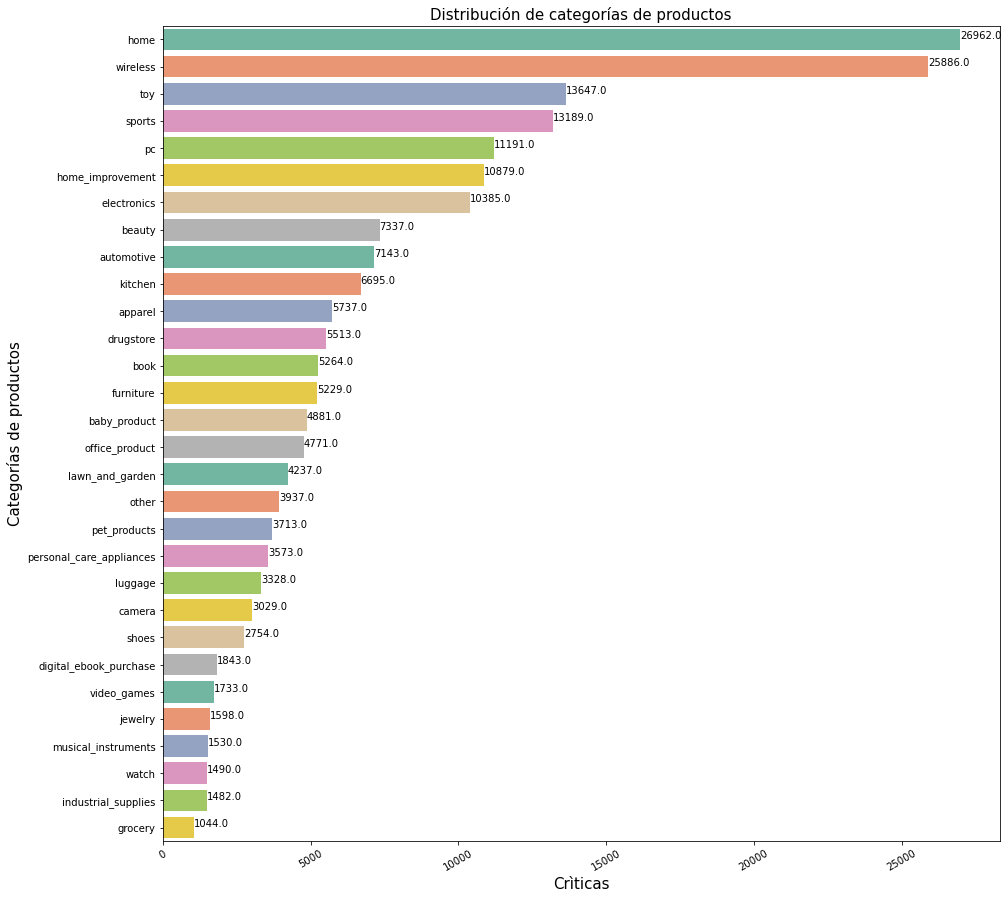

In [12]:
# Cuento cuántos productos tengo en cada categoría y los ordeno de mayor a menor
data3 = data.groupby(['product_category']).count()
# sort df by Count column
data3 = data3.sort_values(['review_id'], ascending=False).reset_index()

plt.figure(figsize=(15,15))
ax = sns.barplot(y = data3.product_category, x = data3.review_id, data = data3, palette="Set2", label='big')
plt.title('Distribución de categorías de productos', fontsize=15)
plt.xlabel('Crìticas', fontsize=15)
plt.xticks(rotation=30)
plt.ylabel('Categorías de productos', fontsize=15)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=10)

Las categorías que más productos tienen son 'home' y 'wireless' (más de 25.000 registros). Se ven después qué categorías tienen registros y cuáles menos registros.  

Voy a definir una función para que sea más sencillo recorrer todas las cateogrías de producto y evaluar la distribución de stars en cada uno. 

No se muestran todos los resultados para no hacer muy extensa la notebook, pero es posible ver cada gráfico cambiando el nombre de la categoría o corriendo el for loop.

In [15]:
def stars_rating(datos,categoria):
    data_categoria = datos[datos['product_category'] == categoria]
    print('Categoría:', categoria)
    print('Registros para esta categoría:', data_categoria.shape[0])
# Ordeno según stars
    data_categoria = data_categoria.sort_values(['stars'], ascending=False).reset_index(drop=False)

    ax = sns.barplot(y = data_categoria.groupby(['stars']).count()['review_id'], x = data_categoria.groupby(['stars']).count().index, data = data_categoria, palette="Set2", label='big')
    plt.title('Distribución de stars', fontsize=15)
    plt.xlabel('Stars', fontsize=15)
    plt.ylabel('Cantidad de productos', fontsize=15)
    plt.show()
    return

Categoría: home
Registros para esta categoría: 26962


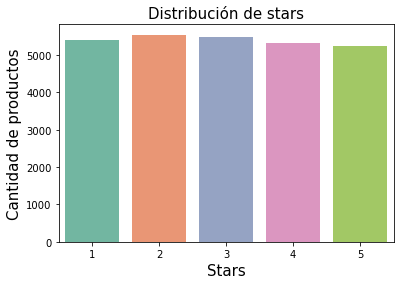

In [16]:
stars_rating(data,'home')

In [ ]:
for i in categorias:
    stars_rating(data,i)

En una inspección visual, las categorías que presentan una distribución de stars menos pareja son:    
Wireless: menos cantidad de productos con mayor cantidad estrellas (3,4,5)   
Luggage: menos cantidad de productos con mayor cantidad estrellas (1,2)  
Lawn_and_garden: menos cantidad de productos con mayor cantidad estrellas (4,5)   
Book: menos cantidad de productos con mayor cantidad estrellas (1,2,3,4)   
Digital_ebook_purchase: menos cantidad de productos con mayor cantidad estrellas (1,2)   
Musical_instruments: menos cantidad de productos con mayor cantidad estrellas (1,2)   

Balanceados: electronics, drugstore, home, office_product, kitchen, pc, toy, industrial_supplies, furniture, pet_products, 
sports, home_improvement, grocery, beauty, other, watch, automotive, apparel, video_games, camera, baby_product, personal_care_appliances, jewelry.

**¿Qué palabras se encuentran más asociadas a cada calificación?**

Para evaluar esto, voy a empezar agrupando las críticas por cantidad de stars y eliminando stopwords. Antes de quitar stopwords voy a quitar de la lista aquellas palabras que pueden ser relevantes para este proyecto, relacionadas con palabras que pueden hacer referencia a calificaciones, cuantificaciones, sentimientos o expresiones de deseos.

In [18]:
data_1_star = data[data['stars'] == 1]
data_2_stars = data[data['stars'] == 2]
data_3_stars = data[data['stars'] == 3]
data_4_stars = data[data['stars'] == 4]
data_5_stars = data[data['stars'] == 5]

stopwords = nltk.corpus.stopwords.words('spanish')
# print('Lista de stopwords:', stopwords)

# Luego de evaluar la lista de stopwords, decido dejar algunas palabras que pueden ser relevantes para el trabajo
palabras = ['muy', 'no', 'si', 'sin', 'sentido', 'sentida', 'sintiendo', 'siente', 'contra', 'muchos', 'poco', 'más', 
            'pero', 'porque', 'tanto', 'sentidos', 'sería', 'fuese', 'tuvo', 'tendría', 'tuviese']
stopwords = [palabra for palabra in stopwords if palabra not in palabras]

# print('Lista de stopwords:', len(stopwords), 'palabras', stopwords)

Defino una función para graficar la lista de palabras más frecuentes en cada dataset.

In [19]:
def freq_palabras(dataset):
    review_body_data = []
# Agrego las review_body
    name =[x for x in globals() if globals()[x] is dataset][0]
    for i in range(dataset.shape[0]):
        review_body_ = dataset.iloc[i].review_body
        review_body_ = review_body_.lower()
        review_body_ = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review_body_)  # [\w]+ Para reconocer caracteres alfanuméricos
        # Pasamos todo a minúsculas

        review_body_ = [word for word in review_body_ if word not in stopwords]
#     review_body_ = [word for word in titular if word not in filtrar]
        review_body_data.append(review_body_)
    
    review_body_data = list(itertools.chain(*review_body_data))
    freq_data = nltk.FreqDist(review_body_data)
    df_data = pd.DataFrame(list(freq_data.items()), columns = ["Word","Frequency"])
    df_data.sort_values('Frequency',ascending=False, inplace = True)
    df_data.reset_index(drop = True, inplace=True)
    
    plt.figure(figsize = (10, 6))
    plt.title('Palabras más frecuentes en dataset %s' %name, fontsize=15)
    plot = sns.barplot(x  = df_data.iloc[:20].Word, y = df_data.iloc[:20].Frequency)
    
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plt.show()
    return

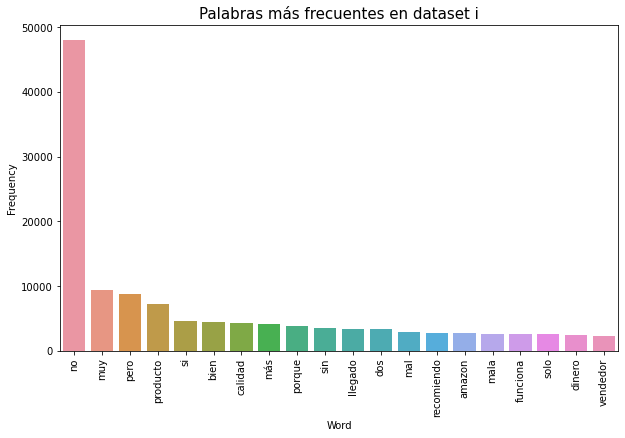

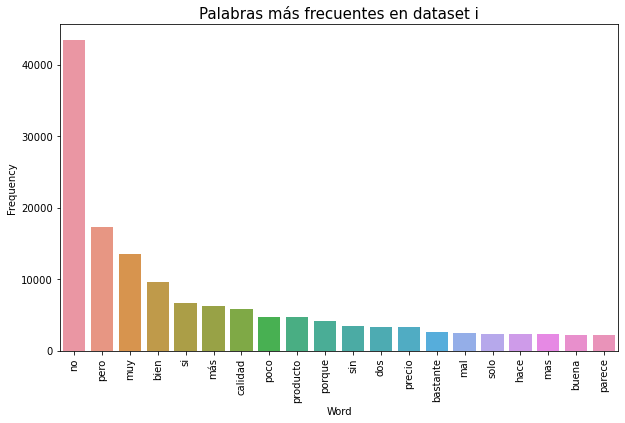

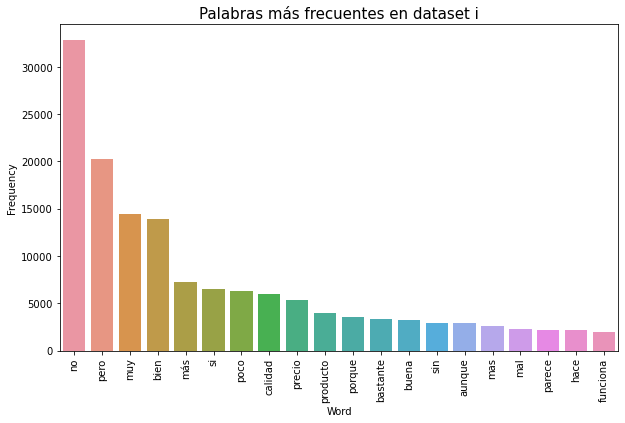

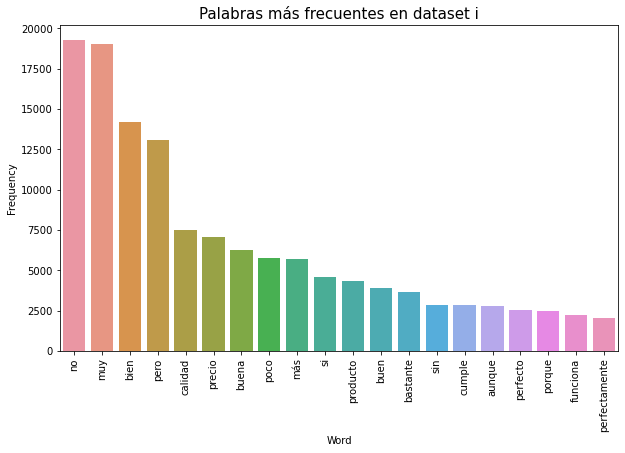

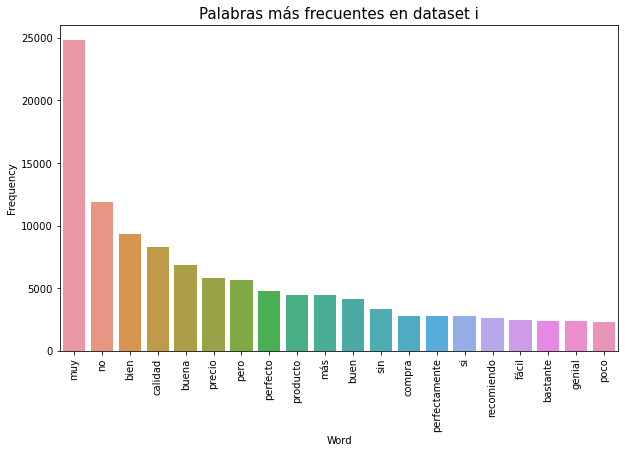

In [23]:
# Recorro los datasets según el filtro de 2, 3 4 y 5 estrellas para ver cuál es la distribución de palabras mśa frecuentes.
datasets = [data_1_star, data_2_stars, data_3_stars, data_4_stars, data_5_stars]

for i in datasets:
    freq_palabras(i)

Las 5 palabras más frecuentes en el sub-dataset de cada estrella son:  

**1 star**: con mucha diferencia, la palabra más utilizada en este dataset es "no". Luego siguen "muy", "pero", "producto", "si".  
**2 stars**: la palabra más utilizada es "no", pero  y tiene una diferencia importante con las siguientes, pero se evidencia que no hay tanta diferencia como en el dataset de 1 star. Las palabras siguientes son "pero", "muy", "bien", "si".  
**3 stars**: la palabra más utilizada también es "no", pero se evidencia que en menor cantidad que en los datasets 1 y 2 (entre 10 y 20 mil veces menos). Le siguen "pero", "muy", "bien" y "más", también con mayor frecuencia que en el dataset de 2 stars.  
**4 stars**: en este dataset las 2 palabras más frecuentes son "no" y "muy" (casi en igual frecuencia) . Le siguen "muy", "bien", "precio" y "calidad". Se ve que hay menor diferencia que en los datasets anteriores en la frecuencia de palabras y que empiezan a aparecer palabras con características de los productos como "precio" y "calidad".   
**5 stars**: en este caso el comportamiento de la frecuencia de palabras es más similar al dataset de 2 estrellas, pero la palabra más empleada es "muy". Le siguen en menor frecuencia "no", "bien", "calidad" y "buena". En este caso y en el dataset anterior, la palabra "buena" y muchas de las siguientes que se observan (al como "perfecto", "perfectamente", "fácil") se pueden asociar a sentimientos de satisfacción.   

Observando estos gráficos, vemos que es posible que estas palabras sean importantes para los modelos en la clasificación de los productos.

### **Parte B - Machine Learning**

Respondiendo a la pregunta de **¿Es un problema de Clasificación o de Regresión?**, considero que este problema puede verse de ambas formas. En el caso de una Clasificación, se podrían considerar a las 5 estrellas equivalentes a poner categorías cualitativas de "malo", "regular", "bueno", "muy bueno" y "excelente" por ejemplo, y emplear un modelo de clasificación de los vistos en las bitácoras del curso. Sin embargo, debido a que estas categorías presentan una diferencia jerárquica entre sí 1 < 2 < 3 < 4 < 5 (**variables numéricas ordinales**) sería más conveniente emplear un modelo de **regresión** para estimar las calificaciones que un clasificador.

Para comenzar a implementar modelos de Machine learning voy a elegir trabajar con la columna "review_body" que es en donde se encuentra la crítica principal. Creo que también sería posible y muy enriquecedor también utilizar también la información de la columna "review_title", pero no la voy a considerar a priori (sería posible agregarla por ejemplo como mejora en el Sprint 4).

**Métricas de evaluación de modelos**

Las métricas que utilizaré para evaluar los modelos son:   
1- Mean Absolute Error (MAE): es el promedio de las diferencias absolutas entre las predicciones y los valores reales. Hay que tener la consideración de que da idea de la magnitud, pero no de la dirección del error.   
2- **Root Mean Squared Error (RMSE)**: se realiza la media cuadrática entre los valores previstos y observados. Como la variable puede tomar valores positivos y negativos, este valor me permite evaluar las diferencias globales entre los valores reales y predichos independientemente de la dirección en la que suceda el error (y que no se cancelen los signos positivos con los negativos). Tiene la característica de que le da más peso a errores mayores de la diferencia (valor real - valor predicho).
Luego convierte el error en las unidades originales de la variable. Utilizaré esta métrica como principal determinante en el análisis.  

En ambos casos, pueden tomar valores que van desde cero a infinito. Cuanto más cercano a cero sea el valor, mejor predictor será el modelo que estoy evaluando, ya que las diferencias de la variable predicha con la real serán menores.

**Preprocesamiento de datos**

El primer preprocesamiento de los datos que voy a realizar es la Normalización empeando el proceso de **Lemmatización**. Elijo esta metodología en lugar de la Stemmización, ya que si bien es computacionalmente más costoso, me permite ir a la raíz de la palabra utilizando el contexto y la función de la palabra en el texto. Debido a que el dataset se encuentra en español NLTK no ha funcionado bien para realizar la lemmatización (no dispone de librerías para este proceso en español) por lo que decido utilizar **spaCy v3.0** que cuenta con buenas referencias para este proceso.

In [25]:
# Importo el dataset de entrenamiento
dataset = pd.read_json('dataset_es_train.json', lines= True)

# Tomo las columnas de interés
dataset=pd.concat([dataset.review_body,dataset.stars],axis=1)
dataset.dropna(axis=0,inplace=True)  # Descarto nan
dataset.head()

,review_body,stars
0,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,1
1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",1
2,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!",1
3,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden",1
4,Llega tarde y co la talla equivocada,1


#### A) Lemmatización

In [20]:
# Cargo el modelo del lenguaje en español
nlp = spacy.load("es_dep_news_trf")

In [21]:
# Función para lemmatizar con spacy
def spacy_lemma(dataset):
    lem_list=[]
    for review_body in dataset.review_body:
        # Convierto a nlp 
        doc = nlp(review_body)
        # Lemmatización
        output = [word.lemma_ for word in doc] 
        # Por ultimo volvemos a unir el titular
        output = " ".join(output)
        # Uno a la lista vacía
        lem_list.append(output)
        # pd.set_option('display.max_colwidth', None)      
    dataset["titular_lemm"] = lem_list  
    return

In [31]:
# Llamo a la función 
spacy_lemma(dataset)

In [32]:
# Guardo el dataset lemmatizado
dataset.to_csv (r'/home/lulu/Documents/Acámica/dataset_lemma.csv', index = False, header=True)

#### B) Vectorizar

In [2]:
# Importo el dataset lemmatizado
dataset_lemma = pd.read_csv('dataset_lemma.csv')
dataset_lemma=pd.concat([dataset_lemma.titular_lemm,dataset_lemma.stars],axis=1)
print(dataset_lemma.shape) # para asegurar que tenga todas las instancias
dataset_lemma.head()

(200000, 2)


,titular_lemm,stars
0,nada bueno él yo ser ka pantalla en menos de 8 mes y no haber recibir respuesta del fabricante,1
1,"horrible , yo tener que comprar otro porque ni yo que saber inglés , ni uno informático , después de uno hora ser capaz de instalar él",1
2,"tú obligar a comprar dos unidad y tú llegar solo uno y no haber forma de reclamar , uno autentico estafa , no compreis ! !",1
3,"no entrar en descalificar al vendedor , solo poder decir que tras dos mes de espera .... seguir sin el producto y tener que contactar con Amazon para reclamar su reembolso . Amazon uno 10 . él hacer cargo del problema , pero yo e desembolsar mi dinero y en dos mes yo él devolver perdida de tiempo total . sin palabra . y tú decidir",1
4,llegar tarde y co el talla equivocado,1


Voy a definir **x** (vector con las palabras en el body review lemmatizado) e **y** (stars) para poder realizar los modelos.  

Elijo max_features = 500 porque mi computadora no procesa los modelos con max_features = 1000, pero los mismos modelos con 1000 features corridos en Google Colab dan resultados muy similares de MAE y RMSE, por lo que no mejoran los modelos y aumenta mucho el costo computacional.

In [3]:
    # Tomamso la lista de palabras y las stars
list_reviews = list(dataset_lemma['titular_lemm'].values)
stars = dataset_lemma['stars'].values

    # Usaremos solo las 500 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features = 500

    # Es decir que cada instancia tendrá 500 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz = cou_vec.fit_transform(list_reviews)
    
    # Tomamos las palabras
all_words = cou_vec.get_feature_names()

x = matriz.toarray()
y = stars
    
unique_elements, counts_elements = np.unique(stars, return_counts=True)
print(unique_elements,counts_elements)

[1 2 3 4 5] [40000 40000 40000 40000 40000]


In [7]:
x.shape

(200000, 500)

Importo el dataset de testeo para evaluar el modelo benchmark y obtengo x_test e y_test para evaluar el modelo benchmark

In [19]:
# Importo el dataset para testear el modelo entrenado
data_test = pd.read_json('dataset_es_test.json', lines= True)
data_test.head()

# Tomamos las columnas de interés
data_test = pd.concat([data_test.review_body,data_test.stars],axis=1)
data_test.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
print(data_test.shape)

# data_test.head()

(5000, 2)


In [40]:
lem_list=[]

for review_body in data_test.review_body:
        # Convierto a nlp 
    doc = nlp(review_body)
        # Lemmatización
    output = [word.lemma_ for word in doc] 
        # Por ultimo volvemos a unir el titular
    output = " ".join(output)
        # Uno a la lista vacía
    lem_list.append(output)
        # pd.set_option('display.max_colwidth', None)
        
data_test["titular_lemm"] = lem_list  

In [9]:
data_test.to_csv (r'/home/lulu/Documents/Acámica/data_test.csv', index = False, header=True)

In [4]:
data_test_lemm = pd.read_csv('data_test.csv')
data_test_lemm=pd.concat([data_test_lemm.titular_lemm,data_test_lemm.stars],axis=1)
data_test_lemm.head()

,titular_lemm,stars
0,no yo llegar el articulo yo él mando por correo normal sin seguimiento y nunca yo llegar tota uno desastre,1
1,"el mensajería horrible , no comprar mas",1
2,estar mucho decepcionado con el vendedor ya que el pedido no yo llegar a tiempo y no cumplir el plazo de envío y ser uno cosa que necesitar urgente . para colmo yo poner en contacto con el vendedor y no dar señal . no recomendar nada,1
3,"mi valoración no ser sobre el producto sino sobre AMAZON . ofrecéis el producto a 299 € y tras varios día yo devolver el dinero porque tú haber equivocar en el anuncio , según tú , ahora ser 399€. ser el primero vez que yo ocurrir este . cuando haber comprar en cualquiera sitio y el precio marcado no él corresponder con el valor de caja siempre yo él haber vender con el precio marcado . ser inverosímil él ocurrido , pero el ultimo palabra yo él dar el oficina del consumidor",1
4,pues tener interés en este libro y probar el versión kindle . él abrir el portada pero nada más . parecer uno malo broma pero yo ir a gastar el dedo de tanto tratar que pasar de página de alguno forma . no poder valorar nada de nada .,1


In [5]:
    # Tomamso la lista de palabras y las stars
list_reviews_test = list(data_test_lemm['titular_lemm'].values)
stars_test = data_test_lemm['stars'].values

matriz_test = cou_vec.transform(list_reviews_test)
    
    # Tomamos las palabras
all_words_test = cou_vec.get_feature_names()

x_test = matriz_test.toarray()
y_test = stars_test
    
unique_elements, counts_elements = np.unique(stars_test, return_counts=True)
print(unique_elements,counts_elements)

[1 2 3 4 5] [1000 1000 1000 1000 1000]


In [10]:
x_test.shape

(5000, 500)

### Modelo 1: Regresión lineal (Benchmark)

In [ ]:
# Realizo la regresión lineal
reg = LinearRegression()
reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(Celdas ejecutadas en Google Colab por capacidad computacional)

In [ ]:
y_train_pred = reg.predict(x)
y_test_pred = reg.predict(x_test)

In [ ]:
# Evalúo el modelo con MAE
mae_train = mean_absolute_error(y, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print('MAE en train:', mae_train)
print('MAE en test:', mae_test)

MAE en train: 0.8534368439049714  
MAE en test: 0.8549808263632028

In [ ]:
# Evalúo el modelo con RMSE
rmse_train = mean_squared_error(y, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print('RMSE en train:', rmse_train)
print('RMSE en test:', rmse_test)

RMSE en train: 1.041702200472837   
**RMSE en test: 1.044617102183501**

Grafico la distribución de errores.

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.distplot(y - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('Distribución de errores en Regresión lineal')
plt.legend()
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
lims = [1, 5]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.tight_layout()
plt.show()

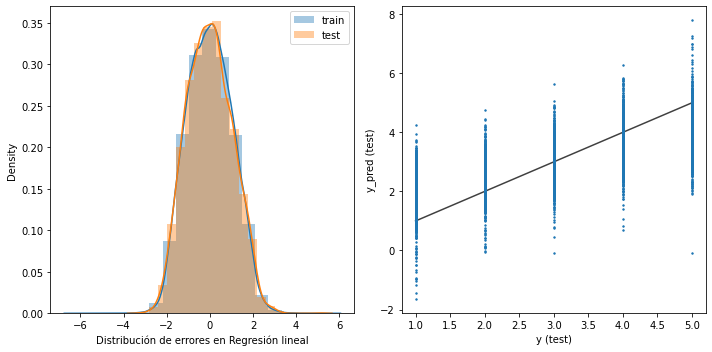

In [1]:
from IPython.display import Image
Image("reglinealerrores.png")  # Corrido en Google Colab

#### **Conclusiones del Modelo benchmark**

Este modelo presenta similares resultados para las métricas de MAE y RMSE para Train y Test, por lo que se puede concluir que no está produciendo ni sobre ni subajuste. El error absoluto está cercano a 0.85, por lo que podríamos esperar una predicción del modelo de +/- 1 star para cada calificación.

Se puede ver que los errores siguen una distribución normal y que se comenten errores tanto positivos como negativos para cada calificación. 

### Modelo 2: Elección del modelo

Realizo una prueba incial con 2 modelos: Random Forest Regressor y XGBoost (con hiperparámetros sin optimizar). En base a su performance elegiré el modelo al cual luego realizaré la optimización de hiperparámetros.

**1) Random Forest Regressor**

In [ ]:
rf = RandomForestRegressor(max_depth=15, random_state=42)  
rf.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Nota: mi computadora tarda demasiado en correr el .fit. Esta parte fue corrida en Google Colab. Se copian los resultados obtenidos. Elegí max_depth = 15 en lugar del parámetro por default "None" debido al costo computacional de dicho modelo.

In [11]:
y_pred_train_rf = rf.predict(x)
y_pred_test_rf = rf.predict(x_test)

In [ ]:
# Evalúo el modelo con MAE
mae_train_rf = mean_absolute_error(y, y_pred_train_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)

print('MAE en train:', mae_train_rf)
print('MAE en test:', mae_test_rf)

MAE en train: 0.8188767238567535    
MAE en test: 0.8535165299346449

In [ ]:
# Evalúo el modelo con RMSE
rmse_train_rf = mean_squared_error(y, y_train_pred_rf, squared=False)
rmse_test_rf = mean_squared_error(y_test, y_test_pred_rf, squared=False)
print('RMSE en train:', rmse_train_rf)
print('RMSE en test:', rmse_test_rf)

RMSE en train: 1.018445602436834   
**RMSE en test: 1.0609530271379266**

**2) XGBoost Regressor**

In [15]:
import xgboost as xgb

# Defino el modelo
xg_reg = xgb.XGBRegressor()

# Entreno el modelo
xg_reg.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# Realizo las predicciones
y_train_pred_xg = xg_reg.predict(x)
y_test_pred_xg = xg_reg.predict(x_test)

In [20]:
# Evalúo el modelo con MAE
mae_train_xg = mean_absolute_error(y, y_train_pred_xg)
mae_test_xg = mean_absolute_error(y_test, y_test_pred_xg)

print('MAE en train:', mae_train_xg)
print('MAE en test:', mae_test_xg)

MAE en train: 0.7317831715399411
MAE en test: 0.7643885960876942


In [21]:
# Evalúo el modelo con RMSE
rmse_train_xg = mean_squared_error(y, y_train_pred_xg, squared=False)
rmse_test_xg = mean_squared_error(y_test, y_test_pred_xg, squared=False)
print('RMSE en train:', rmse_train_xg)
print('RMSE en test:', rmse_test_xg)

RMSE en train: 0.9155445788141784
RMSE en test: 0.9515596338531525


#### **Elección del modelo para optimizar hiperparámetros**

En base a los resultados obtenidos de MAE y RMSE del test set en los 2 modelos candidatos para este proyecto, decido continuar la optimización de hiperparámetros con el modelo **XGBoost Regressor**. 

**XGBoost Regressor**  
MAE en test: 0.7643885960876942    
RMSE en test: 0.9515596338531525  

**Random Forest Regressor**  
MAE en test: 0.8535165299346449   
RMSE en test: 1.0609530271379266

### Optimización de hiperparámetros XGBoost Regressor

In [12]:
param_grid = {
        'max_depth': [1, 2, 3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'n_estimators': [200, 300, 400, 500, 600],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'subsample': [0.6, 0.8, 1.0],
            }

gbm = xgb.XGBRegressor(n_jobs=-1)

In [13]:
randomized_mse = RandomizedSearchCV(param_distributions=param_grid, estimator=gbm, 
#                                     n_iter=20,
                                    scoring="neg_mean_squared_error", 
                                    refit=True, verbose=0, cv=5, random_state=42)
randomized_mse.fit(x, y)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          random_state=None, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_we

In [14]:
print(randomized_mse.best_score_)
print(randomized_mse.best_estimator_)

-1.7119860748630504
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


### Entreno el modelo con los hiperparámetros optimizados

Diferencias con el modelo benchmark: learning_rate=0.2, max_depth=5, n_estimators=400, n_jobs=-1

In [6]:
xg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [7]:
# Entreno el modelo
xg2.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
# Realizo las predicciones
y_train_pred_xg2 = xg2.predict(x)
y_test_pred_xg2 = xg2.predict(x_test)

In [9]:
# Evalúo el modelo con MAE
mae_train_xg2 = mean_absolute_error(y, y_train_pred_xg2)
mae_test_xg2 = mean_absolute_error(y_test, y_test_pred_xg2)

print('MAE en train:', mae_train_xg2)
print('MAE en test:', mae_test_xg2)

MAE en train: 0.7114437967550163
MAE en test: 0.747839562259987


In [10]:
# Evalúo el modelo con RMSE
rmse_train_xg2 = mean_squared_error(y, y_train_pred_xg2, squared=False)
rmse_test_xg2 = mean_squared_error(y_test, y_test_pred_xg2, squared=False)
print('RMSE en train:', rmse_train_xg2)
print('RMSE en test:', rmse_test_xg2)

RMSE en train: 0.8924199283513534
RMSE en test: 0.9362712223904424


In [20]:
# save to JSON
xg2.save_model("model_xg2.json")
# save to text format
xg2.save_model("model_xg2.txt")

/home/lulu/anaconda2/envs/datascience/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lulu/anaconda2/envs/datascience/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


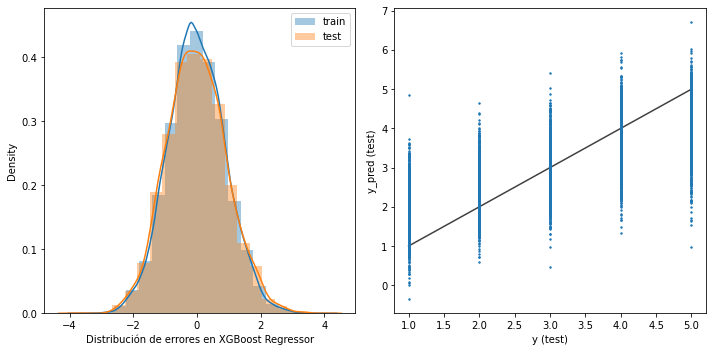

In [16]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.distplot(y - y_train_pred_xg2, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_xg2, bins = 20, label = 'test')
plt.xlabel('Distribución de errores en XGBoost Regressor')
plt.legend()
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_xg2, s =2)
lims = [1, 5]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.tight_layout()
plt.show()

La distribución de errores sigue una distribución normal tanto para el set de entrenamiento como de testeo, y puede verse que el modelo tiene a sobrestimar los productos con 1 star (la mayor parte de los puntos se ubican por encima del 1) y a subestimar las calificaciones de 5 stars (la mayor parte de los puntos se ubica por debajo). Para las 3 calificaciones centrales (2, 3, y 4) las calificaciones son un poco más parejas respecto a la sobre y sub estimación.

### Optimización de hiperparámetros

La optimización de hiperparámetros logró una leve mejora en el desempeño del modelo:

**XGBoost Regressor sin optimización de hiperparámetros**  
MAE en test: 0.7643885960876942    
RMSE en test: 0.9515596338531525  

**XGBoost Regressor con optimización de hiperparámetros**     
MAE en test: 0.747839562259987    
RMSE en test: 0.9362712223904424 

### Features importantes para el modelo

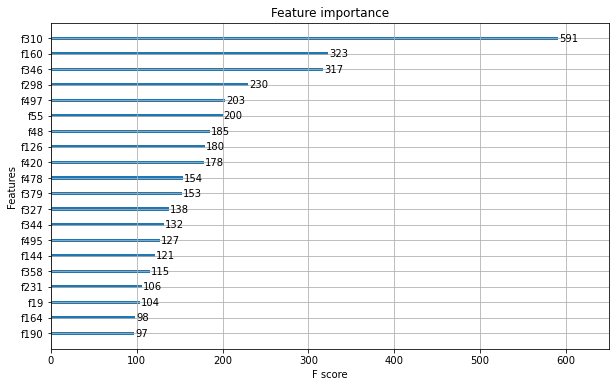

In [114]:
plt.rcParams["figure.figsize"] = (10, 6)
plot_importance(xg2, max_num_features=20)
plt.show()

In [119]:
# Para saber a qué palabra corresponde cada feature
nombres = cou_vec.get_feature_names()
nombres_df = pd.DataFrame(nombres)
nombres_df.iloc[190]

0    estar
Name: 190, dtype: object

Las palabras del gráfico, de mayor a menor score, son: 'no', 'el', 'pero', 'mucho', 'él', 'buen', 'bien', 'de', 'ser', 'uno', 'que', 'para', 'perfecto', 'yo', 'devolver', 'poco', 'haber', 'al', 'en', 'estar'.

Podemos ver que muchas de estas palabras se encontraban en la lista de palabras más frecuentes vistas en la Parte A del proyecto, por lo que era esperable encontrarlas como importantes para el modelo. Algunas de ellas se relacionan con calificativos y tienen asociaciones más positivas o negativas ('bien', 'buen', 'perfecto', 'devolver' o 'poco') y otras no, pero son palabras muy comunes a todas las críticas ('el', 'de', 'que' por ejemplo).

### Accuracy

Para comparar el resultado de este modelo con la conversión del problema a uno binario (ver Parte C) voy a obtener el Accuracy para el XGBoost Regressor optimizado. Para ello comienzo redondeando los valores obtenidos de la regresión al valor entero más próximo, con un rango entre 1 y 5.

In [201]:
y_round = y_test_pred_xg2
y_round = np.round(y_round)
np.unique(y_round)

array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32)

In [202]:
y_final = []

for y in y_round:
    if y < 1:
        y = 1
    elif y > 5:
        y = 5
    else:
        y = y
    y_final.append(y)
        
np.unique(y_final)

array([1., 2., 3., 4., 5.])

In [203]:
# Accuracy sobre XGBoost Regressor
acc = accuracy_score(y_test, y_final)
print('Accuracy sobre XGBoost Regressor:', acc)
acc_2 = accuracy_score(y_test, y_final, normalize=False)
print('Número de instancias correctamente clasificadas por XGBoost Regressor:', acc_2)

Accuracy sobre XGBoost Regressor: 0.41
Número de instancias correctamente clasificadas por XGBoost Regressor: 2050


### **3 - Parte C**


### ¿Problema binario?

Creo que es probable que si se considera como un problema de clasificación las predicciones funcionen mejor convirtiendo el problema a uno binario, ya que el modelo solamente tendría que asignar las calificaciones a una de dos posibles que son opuestas y excluyentes. 

Voy a comenzar realizando un preprocesamiento de los datos convirtiendo las stasr en calificaciones Positivas o Negativas.  
El criterio será el siguiente:     
**Positivo (1): 4 y 5 stars   
Negativo (0): 1 y 2 stars**   

Elimino las calificaciones correspondientes a 3 stars ya que se consideran neutrales. 

In [108]:
# Importo el dataset lemmatizado
dataset_lemma = pd.read_csv('dataset_lemma.csv')
dataset_lemma=pd.concat([dataset_lemma.titular_lemm,dataset_lemma.stars],axis=1)

In [109]:
# Convierto la columna Stars a int
dataset_lemma['stars'] = dataset_lemma['stars'].astype(int)
# Elimino stars = 3 (neutrales)
dataset2 = dataset_lemma[dataset_lemma['stars']!=3]

# Confirmo que sólo me quedo con 1,2,4,5 stars
unique_stars = np.unique(dataset2['stars'])
print(unique_stars)

# Cambio las calificaciones 1 = Positivo (4 y 5 stars), 0 = Negativo (1 y 2 stars)
dataset2["stars"].replace({1: 0, 2: 0, 4: 1, 5: 1}, inplace=True)
dataset2 = dataset2.rename(columns={'stars': 'label'})

# Confirmo que sólo tengo 2 etiquetas con iguales críticas cada una
unique_labels = np.unique(dataset2['label'], return_counts=True)
print(unique_labels)

# dataset2.head()

[1 2 4 5]
(array([0, 1]), array([80000, 80000]))


/home/lulu/anaconda2/envs/datascience/lib/python3.7/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Defino x e y para entrenar los modelos

In [110]:
    # Tomamso la lista de palabras y las stars
list_reviews2 = list(dataset2['titular_lemm'].values)
label2 = dataset2['label'].values

    # Usaremos solo las 500 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features = 500

    # Es decir que cada instancia tendrá 500 features
cou_vec2 = CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz2 = cou_vec2.fit_transform(list_reviews2)
    
    # Tomamos las palabras
all_words2 = cou_vec2.get_feature_names()

x2 = matriz2.toarray()
y2 = label2
    
unique_elements2 = np.unique(label2, return_counts=True)
unique_elements2

(array([0, 1]), array([80000, 80000]))

Repito con el test set

In [111]:
data_test_lemm2 = pd.read_csv('data_test.csv')
data_test_lemm2 = pd.concat([data_test_lemm2.titular_lemm,data_test_lemm2.stars],axis=1)

data_test_lemm2['stars'] = data_test_lemm2['stars'].astype(int) #convert the star_rating column to int 
data_test_lemm2 = data_test_lemm2[data_test_lemm2['stars']!=3]

unique_stars_test2 = np.unique(data_test_lemm2['stars'])
print(unique_stars_test2)

data_test_lemm2["stars"].replace({1: 0, 2: 0, 4: 1, 5: 1}, inplace=True)
data_test_lemm2 = data_test_lemm2.rename(columns={'stars': 'label'})

unique_labels_test2 = np.unique(data_test_lemm2['label'], return_counts=True)
unique_labels_test2

[1 2 4 5]


(array([0, 1]), array([2000, 2000]))

In [112]:
    # Tomamso la lista de palabras y las stars
list_reviews_test2 = list(data_test_lemm2['titular_lemm'].values)
label_test2 = data_test_lemm2['label'].values

matriz_test2 = cou_vec2.transform(list_reviews_test2)
    
    # Tomamos las palabras
all_words_test2 = cou_vec2.get_feature_names()

x_test2 = matriz_test2.toarray()
y_test2 = label_test2
    
unique_elements_test2 = np.unique(label_test2, return_counts=True)
unique_elements_test2

(array([0, 1]), array([2000, 2000]))

Ahora el problema se vuelve una clasificación binaria, por lo que voy a probar con modelos para la clasificación (a) Naive Bayes, b) Regresión logística y c) XGBoost Classifier)

In [113]:
def confusion2(ytest,y_pred):
    names = [0,1]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()
    return

### a) Naive Bayes

In [134]:
nb = GaussianNB()
nb.fit(x2, y2)

GaussianNB()

In [135]:
y_pred_train_nb = nb.predict(x2)
y_pred_test_nb = nb.predict(x_test2)

In [136]:
print("Accuracy en train: ", nb.score(x2,y2))
print("Accuracy en test: ", nb.score(x_test2,y_test2))
acc_nb = accuracy_score(y_test2,y_pred_test_nb, normalize=False)
print('Número de instancias correctamente clasificadas por XGBoost Regressor:', acc_nb)

Accuracy en train:  0.76151875
Accuracy en test:  0.756
Número de instancias correctamente clasificadas por XGBoost Regressor: 3024


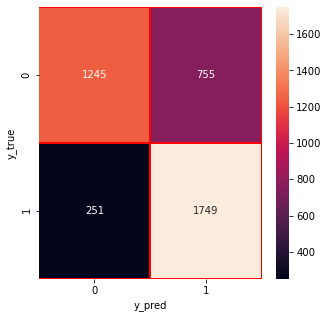

In [11]:
# Realizo la matriz de confusión para el set de entrenamiento
confusion2(y_test2,y_pred_test_nb)

### b) Regresión Logística

In [114]:
from sklearn.linear_model import LogisticRegression

clf2 = LogisticRegression(max_iter=1000).fit(x2,y2)

In [119]:
y_pred_train_clf2 = clf2.predict(x2)
y_pred_test_clf2 = clf2.predict(x_test2)

In [133]:
print("Accuracy en train: ", clf2.score(x2,y2))
print("Accuracy en test: ", clf2.score(x_test2,y_test2))
acc_clf2 = accuracy_score(y_test2,y_pred_test_clf2, normalize=False)
print('Número de instancias correctamente clasificadas por XGBoost Regressor:', acc_clf2)

Accuracy en train:  0.86709375
Accuracy en test:  0.86525
Número de instancias correctamente clasificadas por XGBoost Regressor: 3461


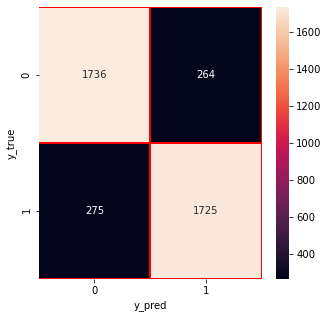

In [123]:
# Realizo la matriz de confusión para el set de entrenamiento
confusion2(y_test2,y_pred_test_clf2)

### c) XGBoost Classifier

In [124]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False)

In [125]:
model.fit(x2, y2)

[00:42:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [126]:
y_pred_train_xg = model.predict(x)
y_pred_test_xg = model.predict(x_test2)

In [132]:
print("Accuracy en train: ", model.score(x2,y2))
print("Accuracy en test: ", model.score(x_test2,y_test2))
acc_xgb = accuracy_score(y_test2,y_pred_test_xg, normalize=False)
print('Número de instancias correctamente clasificadas:', acc_xgb)

Accuracy en train:  0.88230625
Accuracy en test:  0.87125
Número de instancias correctamente clasificadas: 3485


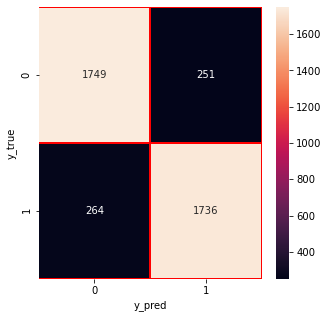

In [129]:
# Realizo la matriz de confusión para el set de entrenamiento
confusion2(y_test2,y_pred_test_xg)

Comparando los accuracy obtenidos en estos 3 modelos binarios vemos que el desempeño es mucho mejor que el obtenido a partir del XGBoost Regressor considerando las 5 calificaciones posibles.

Accuracy sobre XGBoost Regressor: 0.41 (2050/5000 correctamente clasificadas)    
Accuracy sobre Naive Bayes: 0.756 (3024/4000 correctamente clasificadas)   
Accuracy sobre Regresión Logística: 0.86525 (3461/4000 correctamente clasificadas)    
**Accuracy sobre XGBoost Classifier: 0.87125 (3485/4000 correctamente clasificadas)**  

Evaluando estos 3 modelos es posible ver que la mejor performance se logra con XGBoost Classifier. La performance podría mejorarse aún más si realizáramos la optimización de hiperparámetros o incluso sería posible probar otros modelos como Máxima entropía o SVMs. Podría ser de utilidad a la hora de considerar si un producto es satisfactorio para un usuario/a y almacenar dicha información para recomendar productos a dicho usuario/a o a otros usuarios/as, por ejemplo. 


Sería interesante implementar este algoritmo sobre los productos con calificación considerada neutral (3 stars) para evaluar si a partir del texto puede inferirse una calificación Positiva o Negativa para dichos productos.   

In [198]:
dataset3 = dataset_lemma[dataset_lemma['stars'] == 3]
dataset3 = dataset3.rename(columns={'stars': 'label'})    
    
    # Tomamso la lista de palabras y las stars
list_reviews_test3 = list(dataset3['titular_lemm'].values)
label_test3 = dataset3['label'].values

matriz_test3 = cou_vec2.transform(list_reviews_test3)
    
    # Tomamos las palabras
all_words_test3 = cou_vec2.get_feature_names()

x_test3 = matriz_test3.toarray()
y_test3 = label_test3

y_pred_test_xg_3 = model.predict(x_test3)
grupo3 = pd.DataFrame(y_pred_test_xg_3)
grupo3.value_counts()

0    21515
1    18485
dtype: int64

De las 40.000 calificaciones neutrales (3 stars), considerando este modelo podríamos inferir que 21515 (53.8%) se califican como Negativas y 18.485 (46.2%) como positivas. Si bien no es posible hacer una generalización de manera global, podría ser posible que este comportamiento difiera para las diferentes categorías de productos.

### **Conclusiones finales y planes a futuro**

En este proyecto de procesamiento de datos del corpus de Amazon Reviews se han presentado diferentes modelos para la predicción de calificaciones a partir de los comentarios de cada producto. 

Sería posible mejorar el desempeño obtenido empleando análisis más complejos. Quisiera probar a futuro considerar más variables para la predicción del modelo, gbpor ejemplo agregando información del titular y de la categoría del producto. Lo realizaría además intentando emplear una Red neuronal (vista en el encuentro Nº 48 de este curso).

Adicionalmente quisiera mejorar el código de este proyecto, por ejemplo agregando funciones y pipelines en la Parte B de Machine learning. 